# MSc in Data Science - Data Analytics & Algorithms
# Advanced ANN Techniques 

In [18]:
# === Import Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import load_wine
import warnings


In [19]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
from datetime import datetime  # Import the datetime class

# Initialize log file
log_file = 'Ann_Model_log.txt'
def log_entry(message):
    """Append a log entry to the text file with a timestamp."""
    with open(log_file, 'a') as f:
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        f.write(f"[{timestamp}] {message}\n")

# Clear log file if it exists and start fresh
if os.path.exists(log_file):
    os.remove(log_file)
log_entry("=== ANN Model Log Started ===")

In [21]:
# Configure visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [26]:
# === Load and Prepare Data ===
log_entry("Loading data..")
bank_df = pd.read_csv('./Bank Marketing.csv')

In [29]:
# Display basic info
print("Dataset Shape:", bank_df.shape)
print("\nFirst 5 Rows:")
print(bank_df.head())
print("\nTarget Distribution:")
print(bank_df['deposit'].value_counts(normalize=True))

log_entry("Display and verify loaded data.")

Dataset Shape: (11162, 17)

First 5 Rows:
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  

Target Distribution:
deposit
no     0.52616
yes    0.473

In [31]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder
# Encode categorical variables
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                    'contact', 'month', 'poutcome']
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    bank_df[col] = label_encoders[col].fit_transform(bank_df[col])
    
log_entry("Encoded categorical variables.")

In [32]:
# Encode target variable (deposit: no=0, yes=1)
bank_df['deposit'] = bank_df['deposit'].map({'no': 0, 'yes': 1})

In [33]:
# Features and target
X = bank_df.drop(columns=['deposit'])
y = bank_df['deposit']

In [35]:
# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

log_entry("Split data into training, validation, and test sets.")

In [36]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

log_entry("Standardized features using StandardScaler.")

In [37]:
print(f"\nTraining Set Shape: {X_train_scaled.shape}")
print(f"Validation Set Shape: {X_val_scaled.shape}")
print(f"Test Set Shape: {X_test_scaled.shape}")


Training Set Shape: (7813, 16)
Validation Set Shape: (1674, 16)
Test Set Shape: (1675, 16)


In [38]:
# === Define Model Creation Functions ===
def build_regularized_model(input_dim, reg_type=None, reg_strength=0.01, dropout_rate=0, use_batch_norm=False):
    """Build a Sequential model with specified regularization for binary classification."""
    model = Sequential()
    
    # Select regularizer
    if reg_type == 'l1':
        regularizer = l1(reg_strength)
    elif reg_type == 'l2':
        regularizer = l2(reg_strength)
    elif reg_type == 'l1_l2':
        regularizer = l1_l2(l1=reg_strength/2, l2=reg_strength/2)
    else:
        regularizer = None
    
    # Input layer
    model.add(Dense(64, input_dim=input_dim, kernel_regularizer=regularizer))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Hidden layer
    model.add(Dense(32, kernel_regularizer=regularizer))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

log_entry("Defined model creation function.")

In [39]:
def build_multi_branch_model(input_dim):
    """Build a multi-branch model for binary classification using Functional API."""
    inputs = Input(shape=(input_dim,))
    
    # Branch 1: Deep
    b1 = Dense(64, activation='relu')(inputs)
    b1 = BatchNormalization()(b1)
    b1 = Dropout(0.3)(b1)
    b1 = Dense(32, activation='relu')(b1)
    b1 = BatchNormalization()(b1)
    b1 = Dropout(0.3)(b1)
    b1 = Dense(16, activation='relu')(b1)
    
    # Branch 2: Wide
    b2 = Dense(128, activation='relu')(inputs)
    b2 = BatchNormalization()(b2)
    b2 = Dropout(0.3)(b2)
    b2 = Dense(64, activation='relu')(b2)
    
    # Branch 3: Direct with regularization
    b3 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    
    # Merge branches
    merged = Concatenate()([b1, b2, b3])
    outputs = Dense(1, activation='sigmoid')(merged)
    
    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [40]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

In [42]:
from sklearn.metrics import roc_auc_score
# === Experiment 1: Regularization Techniques ===
configs = [
    {'name': 'Baseline', 'reg_type': None, 'reg_strength': 0.0, 'dropout_rate': 0.0, 'use_batch_norm': False},
    {'name': 'L1', 'reg_type': 'l1', 'reg_strength': 0.001, 'dropout_rate': 0.0, 'use_batch_norm': False},
    {'name': 'L2', 'reg_type': 'l2', 'reg_strength': 0.001, 'dropout_rate': 0.0, 'use_batch_norm': False},
    {'name': 'L1_L2', 'reg_type': 'l1_l2', 'reg_strength': 0.001, 'dropout_rate': 0.0, 'use_batch_norm': False},
    {'name': 'Dropout', 'reg_type': None, 'reg_strength': 0.0, 'dropout_rate': 0.3, 'use_batch_norm': False},
    {'name': 'BatchNorm', 'reg_type': None, 'reg_strength': 0.0, 'dropout_rate': 0.0, 'use_batch_norm': True},
    {'name': 'Dropout_BatchNorm', 'reg_type': None, 'reg_strength': 0.0, 'dropout_rate': 0.3, 'use_batch_norm': True},
    {'name': 'L2_Dropout_BatchNorm', 'reg_type': 'l2', 'reg_strength': 0.001, 'dropout_rate': 0.3, 'use_batch_norm': True},
]

results_list = []
training_histories = {}
trained_models = {}

for cfg in configs:
    print(f"\nTraining model: {cfg['name']}")
    model = build_regularized_model(
        input_dim=X_train_scaled.shape[1],
        reg_type=cfg['reg_type'],
        reg_strength=cfg['reg_strength'],
        dropout_rate=cfg['dropout_rate'],
        use_batch_norm=cfg['use_batch_norm']
    )
    history = model.fit(
        X_train_scaled, y_train_full,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_scaled, y_val),
        callbacks=[early_stop],
        verbose=0
    )
    val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    y_pred_prob = model.predict(X_test_scaled, verbose=0)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test ROC-AUC: {roc_auc:.4f}")
    
    results_list.append({
        'Technique': cfg['name'],
        'Val_Accuracy': val_accuracy,
        'Test_Accuracy': test_accuracy,
        'ROC_AUC': roc_auc
    })
    training_histories[cfg['name']] = history
    trained_models[cfg['name']] = model


Training model: Baseline
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 16.
Validation Accuracy: 0.8327
Test Accuracy: 0.8078
Test ROC-AUC: 0.8786

Training model: L1
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation Accuracy: 0.8256
Test Accuracy: 0.7982
Test ROC-AUC: 0.8711

Training model: L2
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation Accuracy: 0.8184
Test Accuracy: 0.7916
Test ROC-AUC: 0.8705

Training model: L1_L2
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation Accuracy: 0.8262
Test Accuracy: 0.7815
Test ROC-AUC: 0.8696

Training model: Dropout
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation Accuracy: 0.8124
Test Accuracy: 0.7869
Test ROC-AUC: 0.8636

Training model: BatchNorm
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 23

In [43]:
log_entry("Trained models with different regularization techniques.")

In [44]:
# Display results
results_df = pd.DataFrame(results_list).sort_values('Test_Accuracy', ascending=False)
print("\nRegularization Techniques Comparison:")
print(results_df)


Regularization Techniques Comparison:
              Technique  Val_Accuracy  Test_Accuracy   ROC_AUC
0              Baseline      0.832736       0.807761  0.878647
5             BatchNorm      0.838112       0.807164  0.881253
1                    L1      0.825567       0.798209  0.871090
2                    L2      0.818399       0.791642  0.870536
4               Dropout      0.812425       0.786866  0.863600
6     Dropout_BatchNorm      0.808841       0.782090  0.858799
3                 L1_L2      0.826165       0.781493  0.869575
7  L2_Dropout_BatchNorm      0.786141       0.772537  0.858110


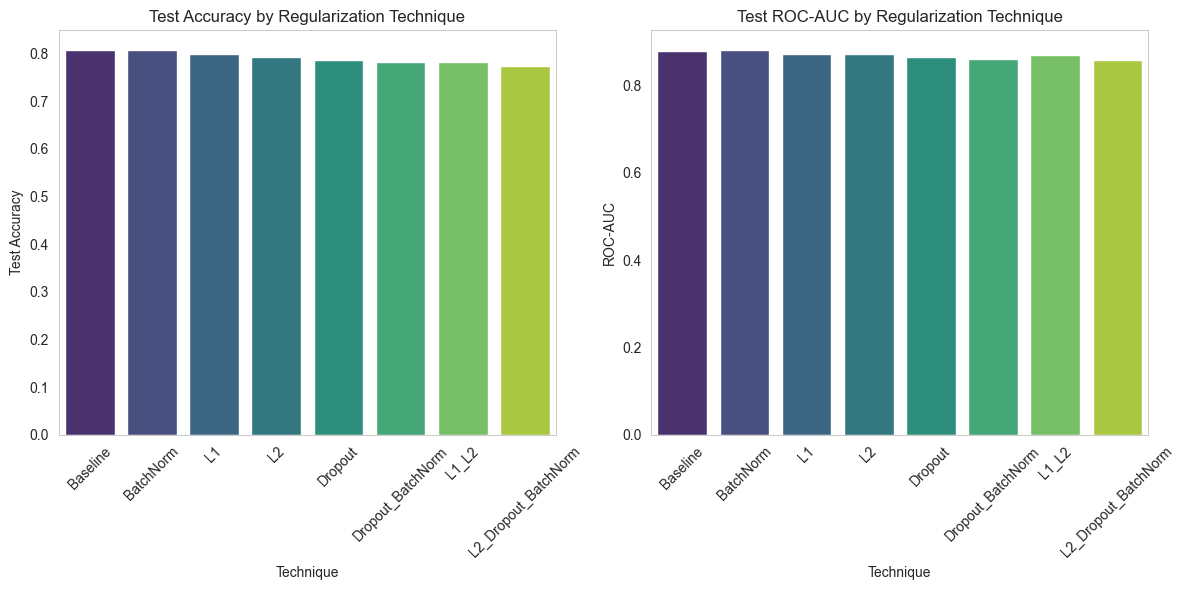

In [47]:
# Visualization: Test accuracy and ROC-AUC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Technique', y='Test_Accuracy', data=results_df, palette='viridis')
plt.title('Test Accuracy by Regularization Technique')
plt.xticks(rotation=45)
plt.ylabel('Test Accuracy')
plt.grid(axis='y')
plt.subplot(1, 2, 2)
sns.barplot(x='Technique', y='ROC_AUC', data=results_df, palette='viridis')
plt.title('Test ROC-AUC by Regularization Technique')
plt.xticks(rotation=45)
plt.ylabel('ROC-AUC')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
log_entry("Displayed test accuracy and ROC-AUC for different regularization techniques.")

In [50]:
# === Experiment 2: Multi-Branch Model ===
print("\nTraining Multi-Branch Model...")
multi_branch_model = build_multi_branch_model(input_dim=X_train_scaled.shape[1])
multi_branch_history = multi_branch_model.fit(
    X_train_scaled, y_train_full,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop],
    verbose=1
)
log_entry("Trained multi-branch model.")


Training Multi-Branch Model...


Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7090 - loss: 0.5869 - val_accuracy: 0.8196 - val_loss: 0.4431
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8016 - loss: 0.4653 - val_accuracy: 0.8190 - val_loss: 0.4244
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8027 - loss: 0.4466 - val_accuracy: 0.8202 - val_loss: 0.4041
Epoch 4/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8157 - loss: 0.4314 - val_accuracy: 0.8280 - val_loss: 0.4001
Epoch 5/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8019 - loss: 0.4467 - val_accuracy: 0.8208 - val_loss: 0.3977
Epoch 6/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8145 - loss: 0.4171 - val_accuracy: 0.8280 - val_loss: 0.3954
Epoch 7/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8203 - loss: 0.4092 - val_accuracy: 0.8286 - val_loss: 0.4022
Epoch 8/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8206 - loss: 0.4182 - val_accu

In [51]:
# Evaluate
test_loss_mb, test_accuracy_mb = multi_branch_model.evaluate(X_test_scaled, y_test, verbose=0)
y_pred_prob_mb = multi_branch_model.predict(X_test_scaled, verbose=0)
y_pred_mb = (y_pred_prob_mb > 0.5).astype(int)
roc_auc_mb = roc_auc_score(y_test, y_pred_prob_mb)
print(f"Multi-Branch Test Accuracy: {test_accuracy_mb:.4f}")
print(f"Multi-Branch Test ROC-AUC: {roc_auc_mb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mb, target_names=['No', 'Yes']))

log_entry("Evaluated multi-branch model on test set.")

Multi-Branch Test Accuracy: 0.7916
Multi-Branch Test ROC-AUC: 0.8710

Classification Report:
              precision    recall  f1-score   support

          No       0.80      0.81      0.80       881
         Yes       0.79      0.77      0.78       794

    accuracy                           0.79      1675
   macro avg       0.79      0.79      0.79      1675
weighted avg       0.79      0.79      0.79      1675



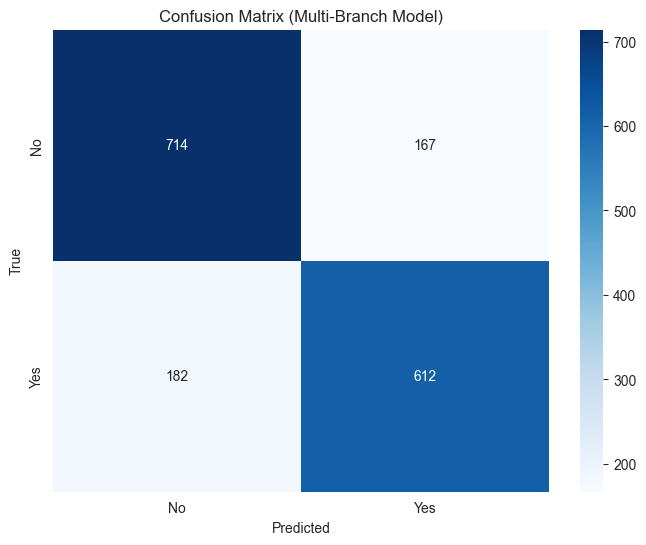

In [52]:
# Confusion matrix
conf_mat_mb = confusion_matrix(y_test, y_pred_mb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_mb, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix (Multi-Branch Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('multi_branch_confusion.png')
plt.show()

In [53]:
# === Experiment 3: Optimizer Comparison ===
def build_simple_model(input_dim):
    """Build a simple ANN for optimizer comparison."""
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

optimizers_dict = {
    'SGD': SGD(learning_rate=0.01, momentum=0.9),
    'SGD_Nesterov': SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    'RMSprop': RMSprop(learning_rate=0.001),
    'Adam': Adam(learning_rate=0.001),
    'Adam_Decay': Adam(learning_rate=0.001, decay=1e-4)
}

opt_results = []
opt_histories = {}

for opt_name, opt in optimizers_dict.items():
    print(f"\nTraining with {opt_name} Optimizer...")
    model = build_simple_model(input_dim=X_train_scaled.shape[1])
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train_scaled, y_train_full,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_scaled, y_val),
        callbacks=[early_stop],
        verbose=0
    )
    val_loss, val_acc = model.evaluate(X_val_scaled, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    y_pred_prob = model.predict(X_test_scaled, verbose=0)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test ROC-AUC: {roc_auc:.4f}")
    
    opt_results.append({
        'Optimizer': opt_name,
        'Val_Accuracy': val_acc,
        'Test_Accuracy': test_acc,
        'ROC_AUC': roc_auc,
        'Epochs': len(history.history['loss'])
    })
    opt_histories[opt_name] = history
    
log_entry(f"Trained model with {opt_name} optimizer.")


Training with SGD Optimizer...
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 44.
Validation Accuracy: 0.8393
Test Accuracy: 0.8090
Test ROC-AUC: 0.8852

Training with SGD_Nesterov Optimizer...
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation Accuracy: 0.8208
Test Accuracy: 0.7887
Test ROC-AUC: 0.8641

Training with RMSprop Optimizer...
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation Accuracy: 0.8088
Test Accuracy: 0.7749
Test ROC-AUC: 0.8590

Training with Adam Optimizer...
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation Accuracy: 0.8053
Test Accuracy: 0.7893
Test ROC-AUC: 0.8601

Training with Adam_Decay Optimizer...
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation Accuracy: 0.7993
Test Accuracy: 0.7672
Test ROC-AUC: 0.8582


In [54]:
# Display optimizer results
opt_df = pd.DataFrame(opt_results).sort_values('Test_Accuracy', ascending=False)
print("\nOptimizer Comparison:")
print(opt_df)

log_entry("Displayed optimizer comparison results.")


Optimizer Comparison:
      Optimizer  Val_Accuracy  Test_Accuracy   ROC_AUC  Epochs
0           SGD      0.839307       0.808955  0.885223      64
3          Adam      0.805257       0.789254  0.860137      20
1  SGD_Nesterov      0.820789       0.788657  0.864067      20
2       RMSprop      0.808841       0.774925  0.858995      20
4    Adam_Decay      0.799283       0.767164  0.858186      20


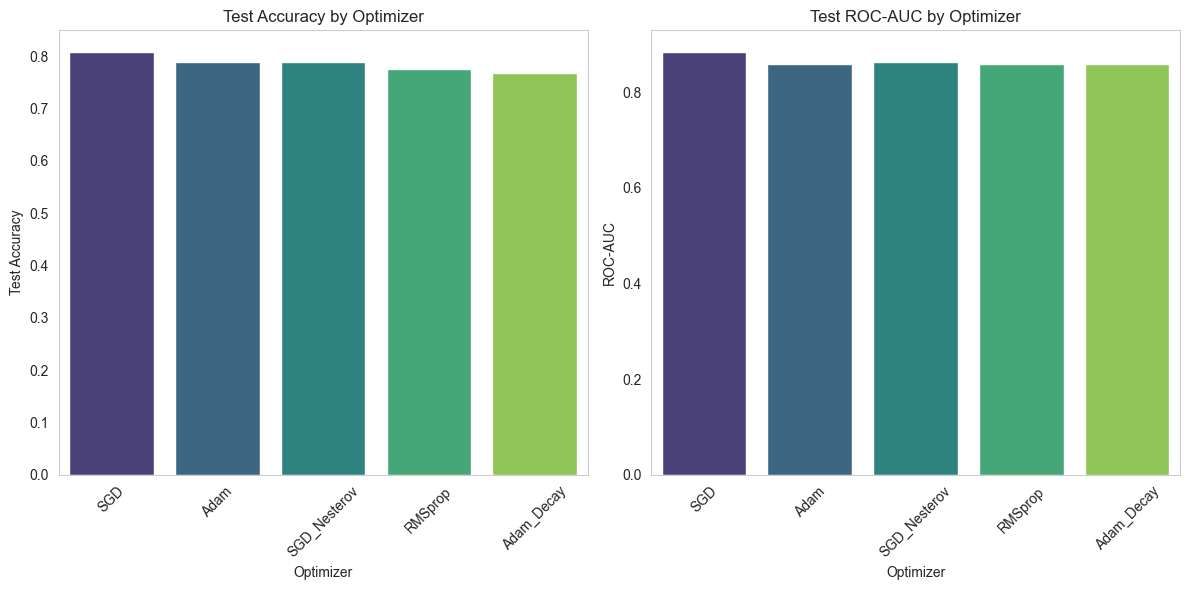

In [56]:
# Visualization: Optimizer comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Optimizer', y='Test_Accuracy', data=opt_df, palette='viridis')
plt.title('Test Accuracy by Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Test Accuracy')
plt.grid(axis='y')
plt.subplot(1, 2, 2)
sns.barplot(x='Optimizer', y='ROC_AUC', data=opt_df, palette='viridis')
plt.title('Test ROC-AUC by Optimizer')
plt.xticks(rotation=45)
plt.ylabel('ROC-AUC')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('optimizer_comparison.png')
plt.show()
log_entry("Displayed test accuracy and ROC-AUC for different optimizers.")



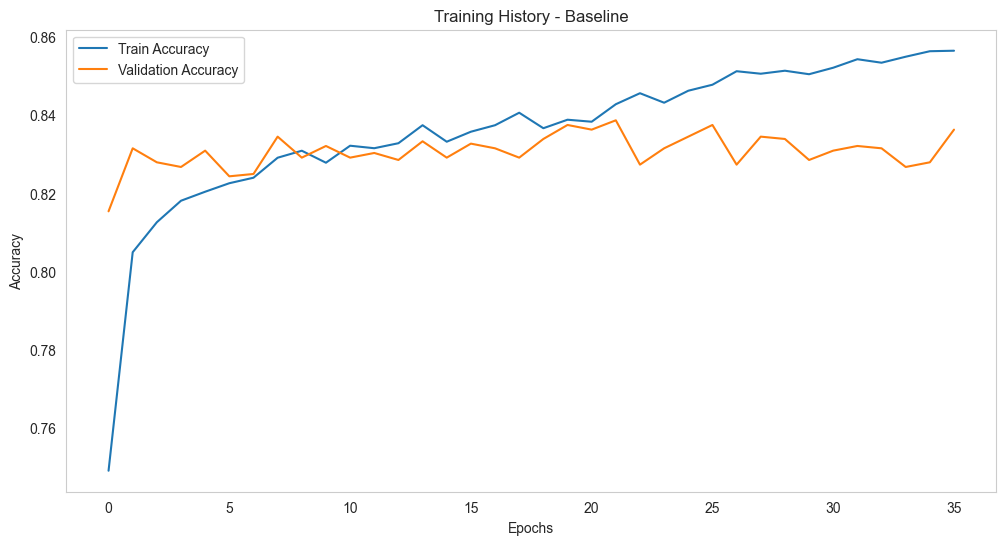

In [57]:
# visualize training history for the best performing model
best_model_name = results_df.iloc[0]['Technique']
best_history = training_histories[best_model_name]
plt.figure(figsize=(12, 6))
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Training History - {best_model_name}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig(f'{best_model_name}_training_history.png')
plt.show()
log_entry(f"Saved training history plot for {best_model_name} model.")

In [61]:
# === Save Model and Preprocessing Artifacts ===
import pickle
import os

# Create directory for deployment artifacts
if not os.path.exists('deployment_artifacts'):
    os.makedirs('deployment_artifacts')

# Save the multi-branch model
multi_branch_model.save('deployment_artifacts/multi_branch_model.h5')

# Save the scaler
with open('deployment_artifacts/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the label encoders
with open('deployment_artifacts/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("Model, scaler, and label encoders saved to 'deployment_artifacts' directory.")

log_entry("Saved model, scaler, and label encoders for deployment.")

2025-03-28 21:02:35,489 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


Model, scaler, and label encoders saved to 'deployment_artifacts' directory.
